### LDA Topic Modeling

In [11]:
import pandas as pd
data = pd.read_csv('data\Merged.csv')

In [12]:
corpus = data['Description']

In [ ]:
len(corpus)

In [ ]:
import re
f = open('C:/Users/HP/Documents/NLP/MySQL_stopwords.txt', 'r', encoding = 'utf-8')
stop_words = f.read()
stop_words = re.split(' \t|\n', stop_words)

In [ ]:
import nltk
from nltk import TweetTokenizer
# stop_words = nltk.corpus.stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def normalize_corpus(corpus):
    normalized_corpus = []
    for i, document in enumerate(corpus):
        # Lowercase
        document = document.lower()
        # Replace 
        document = document.replace("/", " ")
        document = document.replace("’", "'")
        document = document.replace("'s", "")
        # Remove numbers
        document = re.sub('[^A-Za-z0-9\']+', ' ', document)
        # Strip spaces
        document_tokens = tokenizer.tokenize(document)
        # Remove stopwords
        document_tokens = [token for token in document_tokens if token not in stop_words]
        # Lemmatize
        document_tokens = [lemmatizer.lemmatize(token) for token in document_tokens if not token.isnumeric()]
        # Remove single characters
        document_tokens = [token for token in document_tokens if len(token) > 1]
        # Remove empty corpus
        if document_tokens:
            normalized_corpus.append(document_tokens)
    return normalized_corpus
normalized_corpus = normalize_corpus(corpus)

In [ ]:
import gensim
bigram = gensim.models.Phrases(normalized_corpus, min_count = 5, threshold = 5, delimiter = b'_')
bigram_model = gensim.models.phrases.Phraser(bigram)

In [ ]:
normalized_corpus_bigrams = [bigram_model[post] for post in normalized_corpus]
# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(normalized_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))

In [ ]:
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below = 5, no_above = 0.5)
print('Total Vocabulary Size:', len(dictionary))

In [ ]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in normalized_corpus_bigrams]
import pickle
pickle.dump(bow_corpus, open('bow_corpus.pkl', 'wb'))

In [ ]:
MALLET_PATH = 'C:/mallet-2.0.8/bin/mallet'
import os
from gensim.models.wrappers import LdaMallet
from tqdm import tqdm
os.environ['MALLET_HOME'] = 'C:/mallet-2.0.8'

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count = 1, end_topic_count = 10, step = 1,
                                    cpus = 8):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count + 1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path = MALLET_PATH, corpus = corpus,
                                                            num_topics = topic_nums, id2word = dictionary,
                                                            iterations = 100, workers = cpus, random_seed = 20210224)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model = mallet_lda_model, corpus = corpus, 
                                                                     texts = texts, dictionary = dictionary, 
                                                                     coherence = 'c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    return models, coherence_scores

### 25 Topics

In [ ]:
# start_topic_count = 1
# end_topic_count = 25
# lda_models, coherence_scores = topic_model_coherence_generator(corpus = bow_corpus, texts = normalized_corpus_bigrams,
#                                                                dictionary = dictionary, start_topic_count = start_topic_count,
#                                                                end_topic_count = end_topic_count, step = 1, cpus = 8)
# import pickle
# pickle.dump(lda_models, open('25_topics_lda_models.pkl', 'wb'))
# pickle.dump(coherence_scores, open('25_topics_coherence_scores.pkl', 'wb'))

In [ ]:
# lda_models = pickle.load(open('25_topics_lda_models.pkl','rb'))
# coherence_scores = pickle.load(open('25_topics_coherence_scores.pkl','rb'))

### 50 Topics

In [ ]:
# start_topic_count = 1
# end_topic_count = 50
# lda_models, coherence_scores = topic_model_coherence_generator(corpus = bow_corpus, texts = normalized_corpus_bigrams,
#                                                                dictionary = dictionary, start_topic_count = start_topic_count,
#                                                                end_topic_count = end_topic_count, step = 1, cpus = 8)
# pickle.dump(lda_models, open('50_topics_lda_models.pkl', 'wb'))
# pickle.dump(coherence_scores, open('50_topics_coherence_scores.pkl', 'wb'))

In [ ]:
# lda_models = pickle.load(open('50_topics_lda_models.pkl','rb'))
# coherence_scores = pickle.load(open('50_topics_coherence_scores.pkl','rb'))

### 100 Topics

In [ ]:
# start_topic_count = 1
# end_topic_count = 100
# lda_models, coherence_scores = topic_model_coherence_generator(corpus = bow_corpus, texts = normalized_corpus_bigrams,
#                                                                dictionary = dictionary, start_topic_count = start_topic_count,
#                                                                end_topic_count = end_topic_count, step = 1, cpus = 8)
# pickle.dump(lda_models, open('100_topics_lda_models.pkl', 'wb'))
# pickle.dump(coherence_scores, open('100_topics_coherence_scores.pkl', 'wb'))

In [1]:
import pickle
lda_models = pickle.load(open('100_topics_lda_models.pkl','rb'))
coherence_scores = pickle.load(open('100_topics_coherence_scores.pkl','rb'))

### Analyze Model

In [2]:
import numpy as np
import pandas as pd
end_topic_count = 100
coherence_df = pd.DataFrame({'Number of Topics': range(1, end_topic_count + 1, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df = coherence_df.sort_values(by = 'Coherence Score', ascending = False).head(10)

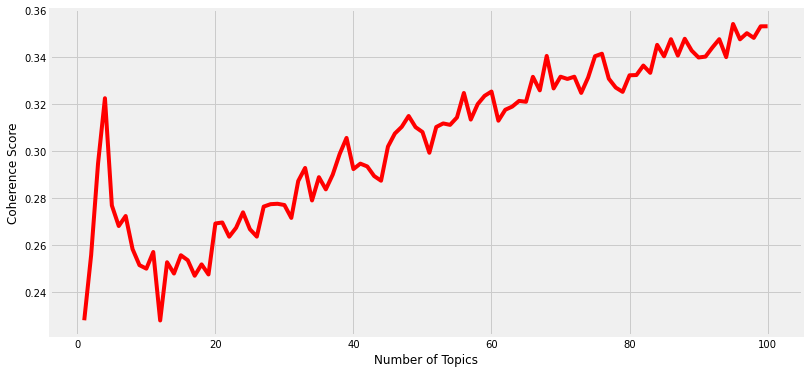

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(1, end_topic_count + 1, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c = 'r')
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [4]:
best_model_idx = coherence_df['Number of Topics'].index[1]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

100

In [5]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn = 20)] 
                   for n in range(0, best_lda_model.num_topics)]

In [6]:
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Topic Desc'],
                         index = range(1, best_lda_model.num_topics + 1)
                         )
topics_df.head()

,Topic Desc
1,"image, feature, making, vision, create, groundbreaking, year, cinema, future, show, shadow, including, authority, empathetic, photograph, fact, citizen, alberto, smith, norman"
2,"played, close, young_man, life, live, real_life, startling, existence, debut, jealousy, american_independent, form, connection, emotion, sex, portrait_woman, back, visual, operatic, tower"
3,"epic, famous, action, decade, age, adventure, moral, modern, exploit, visual, middle, detail, striking, documentary, machine, stop, legendary, talking, viewer, universe"
4,"american, war, release, remains, state, featuring, directed, fight, crisis, sensation, gripping, ren, leading, texas, target, razor, perfect, suburban, uncovers, group"
5,"director, film, international, shot, world, dramatic, collaborator, heartbreaking, street, woman, winner, emotionally, screen, tragedy, film_festival, demon, frequent, movie, cemented, violence"


In [7]:
bow_corpus = pickle.load(open('bow_corpus.pkl','rb'))

In [8]:
tm_results = best_lda_model[bow_corpus]

In [9]:
corpus_topics = [sorted(topics, key = lambda record: -record[1])[0] for topics in tm_results]

In [13]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(corpus))
corpus_topic_df['Dominant Topic'] = [item[0] + 1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1] * 100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Topic Desc'] for t in corpus_topics]
corpus_topic_df['Description'] = corpus
corpus_topic_df.head()

,Document,Dominant Topic,Contribution %,Topic Desc,Description
0,0,88,9.55,"godard, anna, marriage, star, iconic, french_wave, relationship, thing, medium, entertaining, landmark, jean_luc, fashion, actress, institution, witness, word, helped, collaboration, mental","In 2 OR 3 THINGS I KNOW ABOUT HER (2 OU 3 CHOSES QUE JE SAIS D’ELLE), Jean-Luc Godard beckons us ever closer, whispering in our ears as narrator. About what? Money, sex, fashion, the city, love, language, war: in a word, everything. Among the legendary French filmmaker’s finest achievements, the film takes as its ostensible subject the daily life of Juliette Janson (Marina Vlady), a housewife from the Paris suburbs who prostitutes herself for extra money. Yet this is only a template for Godard to spin off into provocative philosophical tangents and gorgeous images. 2 OR 3 THINGS I KNOW ABOUT HER is perhaps Godard’s most revelatory look at consumer culture, shot in ravishing widescreen color by Raoul Coutard."
1,1,90,4.48,"day, long, narrative, school, 1950s, drive, modern, early, iranian, arrival, expression, plot, cold, revenge, humanity, shot, drawing, villager, act, grave","Iranian master Jafar Panahi’s fourth feature since he was officially banned from filmmaking is a courageous act of antipatriarchal defiance from an artist who has refused to be silenced. This playful docufiction road movie begins with a smartphone video sent to the director and real-life star actress Behnaz Jafari from a desperate young woman who, distraught at her family’s refusal to let her study drama, seemingly records her own suicide. Traveling to the woman’s rural hometown to investigate, Panahi and Jafari find themselves launched on a slyly comic, quietly revelatory journey that builds in narrative, thematic, and visual intricacy to put forth a grand expression of community and solidarity under the eye of oppression."
2,2,90,5.49,"day, long, narrative, school, 1950s, drive, modern, early, iranian, arrival, expression, plot, cold, revenge, humanity, shot, drawing, villager, act, grave","Romanian filmmaker Cristian Mungiu shot to international prominence with this rigorously realistic Palme d’Or–winning second feature. In 1987, during the dictatorship of Nicolae Ceaușescu, college roommates Otilia (Anamaria Marinca) and Găbița (Laura Vasiliu) seek an illegal abortion for Găbița. In unflinching but empathetic detail, the film recounts the events of twenty-four perilous hours in their lives, culminating in their encounter with a manipulative and menacing abortionist (Vlad Ivanov). With powerful performances that accentuate the characters’ flawed humanity, 4 MONTHS, 3 WEEKS AND 2 DAYS is a gutting account of the impossible choices women face when taking control of their bodies means breaking the law."
3,3,71,6.88,"game, film, search, individual, approach, figure, olympiad, olympic_winter, special, young_woman, medieval, strength, competition, bud_greenspan, meaning, eye, influential, exciting, intimacy, jury_prize","Director Tancred Ibsen's penchant for depicting rustic life shines through in the bucolic scenes at the start of THE VI OLYMPIC WINTER GAMES, OSLO 1952. In addition to the exciting scenes of competition (Winter sports are followed with almost rabid fervor in Scandinavia), Ibsen records a sense of community spirit shared among the competitors."
4,4,85,6.36,"filmmaker, life, journey, acclaimed, footage, childhood, intimate, actor, project, dream, creates, follow, marcello_mastroianni, magic, longtime, nuanced, made, complex, autobiography, frame","Marcello Mastroianni plays Guido Anselmi, a director whose new project is collapsing around him, along with his life. One of the greatest films about film ever made, Federico Fellini’s 8½ (Otto e mezzo) turns one man’s artistic crisis into a grand epic of the cinema. An early working title for 8½ was THE BEAUTIFUL CONFUSION, and Fellini’s masterpiece is exactly that: a shimmering dream, a circus, and a magic act."


In [14]:
data['Topic'] = corpus_topic_df['Dominant Topic']
data['Topic Description'] = corpus_topic_df['Topic Desc']

In [15]:
data = data[['Title', 'Director', 'Country', 'Year', 'Decade', 'Duration',
       'Description', 'Url', 'averageRating', 'numVotes', 'Topic',
       'Topic Description']]

In [16]:
data.to_csv('data\Topics.csv', index = False)

In [17]:
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').count()
topic_stats_df = topic_stats_df.drop(['Contribution %', 'Topic Desc', 'Description'], axis = 1)
topic_stats_df.columns = ['# of Docs']
topic_stats_df['% Total Docs'] = round(100 * topic_stats_df['# of Docs'] / sum(topic_stats_df['# of Docs']), 2)
topic_stats_df['Topic Desc'] = topics_df['Topic Desc']
topic_stats_df.sort_values('% Total Docs', ascending = False).head()

,# of Docs,% Total Docs,Topic Desc
Dominant Topic,,,
81,38,2.65,"samurai, godzilla, monster, series, make, earth, action, clan, akira_kurosawa, toshiro_mifune, alien, kurosawa, return, sequel, japan, warrior, thrilling, planet, ghost, king"
56,30,2.09,"music, musical, score, cinematic, song, jazz, blue, composer, shadow, coming_age, studio, musician, bond, johnny, lone_wolf, kim, seller, ogami, female, hired"
98,29,2.02,"young, student, kinoshita, friend, directed_keisuke, visit, desert, member, caught, blind, decides, college, define, grow, friendship, andr, field, health, prove, life_death"
12,25,1.74,"comedy, star, silent, comic, legend, genius, chaplin, showcase, gag, stunt, set_piece, charlie_chaplin, kie_lowski, polish, ultimate, traveling, peak, protect, packed, tramp"
84,23,1.60,"work, film, ingmar_bergman, light, bergman, swedish, presented, making, major, experiment, astonishing, glass, trilogy, sj, winter, winner, spend, sven_nykvist, harriet_andersson, ingrid"


In [18]:
topic_stats_df.sort_values('% Total Docs', ascending = False).tail()

,# of Docs,% Total Docs,Topic Desc
Dominant Topic,,,
3,6,0.42,"epic, famous, action, decade, age, adventure, moral, modern, exploit, visual, middle, detail, striking, documentary, machine, stop, legendary, talking, viewer, universe"
6,5,0.35,"family, film, moving, exquisite, simple, debut_feature, japanese, photographed, written, feel, life, cutting, mm, revelation, refugee, insight, takashi, setup, view, italian_cinema"
5,5,0.35,"director, film, international, shot, world, dramatic, collaborator, heartbreaking, street, woman, winner, emotionally, screen, tragedy, film_festival, demon, frequent, movie, cemented, violence"
60,5,0.35,"cinema, shot, form, war, tender, german, homage, change, emotional, pioneer, sense, star, max, book, cinematography, ophuls, vivid, direction, pure, intimate"
38,4,0.28,"world, tale, set, time, human, cinematic, theme, final_film, rural, artistic, unforgettable, poor, protagonist, beautifully, creation, political, cinematic_experience, material, humanity, grim"


In [19]:
relevant_posts = corpus_topic_df.groupby('Dominant Topic') \
.apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0]))
relevant_posts.sort_values('Contribution %', ascending = False).head()

,Document,Dominant Topic,Contribution %,Topic Desc,Description
Dominant Topic,,,,,
12,228,12,26.20,"comedy, star, silent, comic, legend, genius, chaplin, showcase, gag, stunt, set_piece, charlie_chaplin, kie_lowski, polish, ultimate, traveling, peak, protect, packed, tramp","In the last film he made during the silent era, Charlie Chaplin revels in the art of the circus, paying tribute to the acrobats and pantomimists who inspired his virtuoso pratfalls. After being mistaken for a pickpocket, Chaplin’s Tramp flees into the ring of a traveling circus and soon becomes the star of the show, falling for the troupe’s bareback rider along the way. Despite its famously troubled production, this gag-packed comedy ranks among Chaplin’s finest, thanks to some of the most audacious set pieces of the director-performer’s career, including a close brush with a lion and a climactic tightrope walk with a barrelful of monkeys. THE CIRCUS, which was rereleased in 1969 with a new score by Chaplin, is an uproarious high-wire act that showcases silent cinema’s most popular entertainer at the peak of his comic powers."
64,906,64,25.76,"hope, friend, parent, return, accident, leave, von, thief, make, finding, car, marry, eva, married, travel, tradition, scottish, fair, physical, dream","When Valdemar Moreaux a carousel operator in a travelling fun-fair owned by his girl friend, learns that he is the bastard son of an aristocrat, he moves into his father's manor to be made over into aristocrat himself. It is he the hope of Colonel von Brede, the father, that Valdemar will be made worthy of carrying on the von Brede name and inherit his property. Von Brede is also the guardian of the beautiful and highly intelligent Eva Beckman (Ingrid Bergman). His other hope is that Valdemar and Eva will fall in love and get married. The initial coolness between this young couple gradually disappears and they agree to marry. But all hopes are dashed when Eva is confronted with the physical side of love, which she finds disgusting. Valdemar then realizes that he cannot be made over into another person and he returns to the fair and the honest simplicity of his former girl friend, Helga Mårtensson."
76,1185,76,23.63,"lover, cinematographer, unique, run, style, capture, result, master, young, depth, offer, celebrated, reveals, glimpse, wide, simple, ray, romance, pedro, evolution","In 1959, Yasujiro Ozu remade his 1934 silent classic A STORY OF FLOATING WEEDS in color with the celebrated cinematographer Kazuo Miyagawa (RASHOMON, UGETSU). Setting his later version in a seaside location, Ozu otherwise preserves the details of his elegantly simple plot wherein an aging actor returns to a small town with his troupe and reunites with his former lover and illegitimate son, a scenario that enrages his current mistress and results in heartbreak for all. Together, the films offer a unique glimpse into the evolution of one of cinema’s greatest directors. A STORY OF FLOATING WEEDS reveals Ozu in the midst of developing his mode of expression; FLOATING WEEDS reveals his distinct style at its pinnacle. In each, the director captures the joy and sadness in everyday life."
14,1239,14,22.93,"theater, nazi, thriller, criminal, noir, case, suspense, mystery, feature, filmmaking, version, career, opera, underworld, dr, britain, inspector, landmark, lang, complete","Locked away in an asylum for a decade and teetering between life and death, the criminal mastermind Doctor Mabuse (Rudolf Klein-Rogge) has scribbled his last will and testament: a manifesto establishing a future empire of crime. When the document’s nefarious writings start leading to terrifying parallels in reality, it’s up to Berlin’s star detective, Inspector Lohmann (Otto Wernicke, reprising his role from M) to connect the most fragmented, maddening clues in a case unlike any other. A sequel to his enormously successful silent film DR. MABUSE: THE GAMBLER, Fritz Lang’s THE TESTAMENT OF DR. MABUSE reunites the director with 